<h1>Part 2</h1>

In [1]:
# Imports
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import osmnx as ox
import os
import glob
from geopandas import GeoDataFrame
from shapely.geometry import Point, LineString
from shapely.geometry import Point, box
import geopandas as gpd
import folium
import spaghetti
import esda
from sklearn.cluster import KMeans
from prov.model import ProvDocument
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable

/opt/anaconda3/envs/nda/lib/python3.13/site-packages/spaghetti/network.py:41: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(dep_msg, FutureWarning, stacklevel=1)


<h2>Task A</h2>

In [2]:
PLACE_OF_INTEREST = 'Leeds, United Kingdom'
# Get the geographical area of Leeds from OpenStreetMap as a GeoDataFrame
leeds_gdf = ox.geocode_to_gdf(PLACE_OF_INTEREST)
# From this take the polygon that defines Leeds's boundary
leeds_polygon = leeds_gdf.geometry.iloc[0].buffer(10 / 111_000)

In [3]:
DATA_DIR = "./data"
USE_COLS = ['Grid Ref: Easting', 'Grid Ref: Northing']

# We need to load and collate all CSV files into a single dataframe
months_df = [pd.read_csv(csv_file, usecols=USE_COLS, encoding='ISO-8859-1') \
                for path, subdir, _ in os.walk(DATA_DIR) \
                 for csv_file in glob.glob(os.path.join(path, "*.csv"))]

print("Found {} CSV files in {}".format(len(months_df), DATA_DIR))

leeds_df = pd.concat(months_df, axis=0, ignore_index=True)
print("Total number of accidents loaded: {}".format(len(leeds_df)))

Found 7 CSV files in ./data
Total number of accidents loaded: 16284


In [4]:
# Some accidents do not record a location, so drop any that have 'NaN' for the longitude or latitude
located_accidents = leeds_df.dropna(subset=['Grid Ref: Easting', 'Grid Ref: Northing'])
print("Total number of located accidents filtered: {}".format(len(located_accidents)))

Total number of located accidents filtered: 16284


In [5]:
# Translate to a GeoDatFrame where the geometry is given by a Point constructed from the longitude and latitude
accident_points = GeoDataFrame(geometry=[Point(xy) for xy in zip(
    located_accidents['Grid Ref: Easting'], located_accidents['Grid Ref: Northing'])])

print("Total number of located accidents filtered: {}".format(len(accident_points)))
accident_points.set_crs(epsg=27700, inplace=True)
accident_points.head()

Total number of located accidents filtered: 16284


geometry
0  POINT (418241 442351)
1  POINT (424993 432898)
2  POINT (431159 436397)
3  POINT (431159 436397)
4  POINT (439313 432376)

In [6]:
accident_points = accident_points.to_crs(epsg=4326)
# Filter the accident points to just those within Leeds, as defined by the polygon found earlier
leeds_accidents = accident_points[accident_points.geometry.within(leeds_polygon)]
leeds_accidents

geometry
0      POINT (-1.72403 53.87706)
1       POINT (-1.6221 53.79182)
2      POINT (-1.52816 53.82293)
3      POINT (-1.52816 53.82293)
4      POINT (-1.40481 53.78624)
...                          ...
16279  POINT (-1.54106 53.77605)
16280  POINT (-1.57996 53.82357)
16281   POINT (-1.6929 53.80443)
16282  POINT (-1.51624 53.81813)
16283  POINT (-1.67409 53.81961)

[16284 rows x 1 columns]

In [7]:
def findAccidentsArea(accidents):

    square_size = 1000
    step = 250
    min_x, min_y, max_x, max_y = accidents.total_bounds
    maxCount = 0
    bestBox = None

    for x in np.arange(min_x, max_x, step):
        for y in np.arange(min_y, max_y, step):
            square = box(x, y, x + square_size, y + square_size)
            count = accidents.within(square).sum()

            if count > maxCount:
                maxCount = count
                bestBox = square

    return bestBox, maxCount

In [8]:
accidents = leeds_accidents.to_crs(epsg=27700)
bestSquare, count = findAccidentsArea(accidents)
print(f"Most accidents in 1 km² window: {count}")
centerCoordinates = bestSquare.centroid
print(f"Bounding box center coordinates: {centerCoordinates}")

Most accidents in 1 km² window: 657
Bounding box center coordinates: POINT (430494.9999999998 433657.0000000003)


In [9]:
polygon = bestSquare

polygon = (gpd.GeoSeries([polygon], crs="EPSG:27700").to_crs("EPSG:4326")).iloc[0]

G = ox.graph_from_polygon(polygon=polygon, network_type='drive')

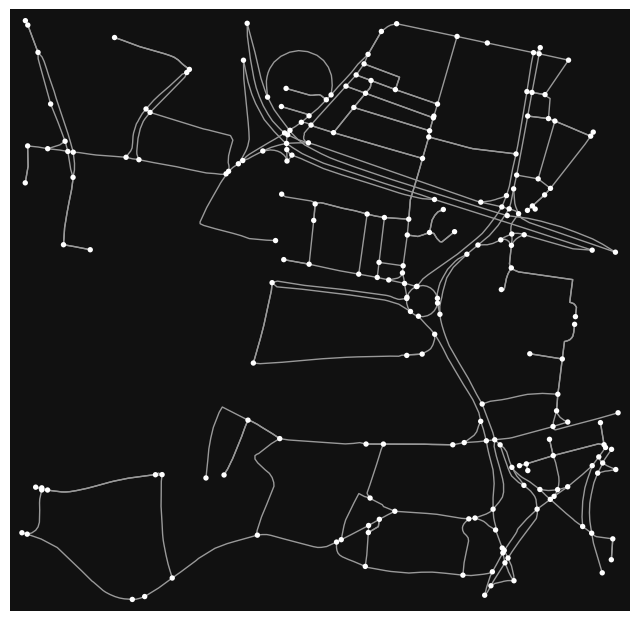

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [10]:
ox.plot_graph(G)

In [11]:
# Force CRS to EPSG:27700 if it's missing
square_gdf = gpd.GeoSeries([bestSquare], crs="EPSG:27700")
stats = ox.basic_stats(G, area=1000000)
stats

{'n': 217,
 'm': 365,
 'k_avg': 3.3640552995391704,
 'edge_length_total': 21992.756221781914,
 'edge_length_avg': 60.25412663501894,
 'streets_per_node_avg': 2.9308755760368665,
 'streets_per_node_counts': {0: 0, 1: 21, 2: 11, 3: 149, 4: 34, 5: 2},
 'streets_per_node_proportions': {0: 0.0,
  1: 0.0967741935483871,
  2: 0.05069124423963134,
  3: 0.6866359447004609,
  4: 0.15668202764976957,
  5: 0.009216589861751152},
 'intersection_count': 196,
 'street_length_total': 18283.69358994342,
 'street_segment_count': 297,
 'street_length_avg': 61.56125787859738,
 'circuity_avg': 1.0366403377405382,
 'self_loop_proportion': 0.0,
 'node_density_km': 217.0,
 'intersection_density_km': 196.0,
 'edge_density_km': 21992.756221781914,
 'street_density_km': 18283.69358994342}

In [12]:
is_planar, kuratowski_subgraphs = nx.check_planarity(G, counterexample=True)
is_planar

False

In [13]:
def plot_graph_folium(graph):
    # convert the graph to GeoDataFrames
    nodes, edges = ox.graph_to_gdfs(graph)

    # create a Folium map centered around the graph's centroid
    edges_union = edges.geometry.union_all()
    centroid = edges_union.centroid
    m = folium.Map(location=[centroid.y, centroid.x], zoom_start=14)

    # add the edges to the map
    folium.GeoJson(edges).add_to(m)

    # display the map
    display(m)
plot_graph_folium(G)

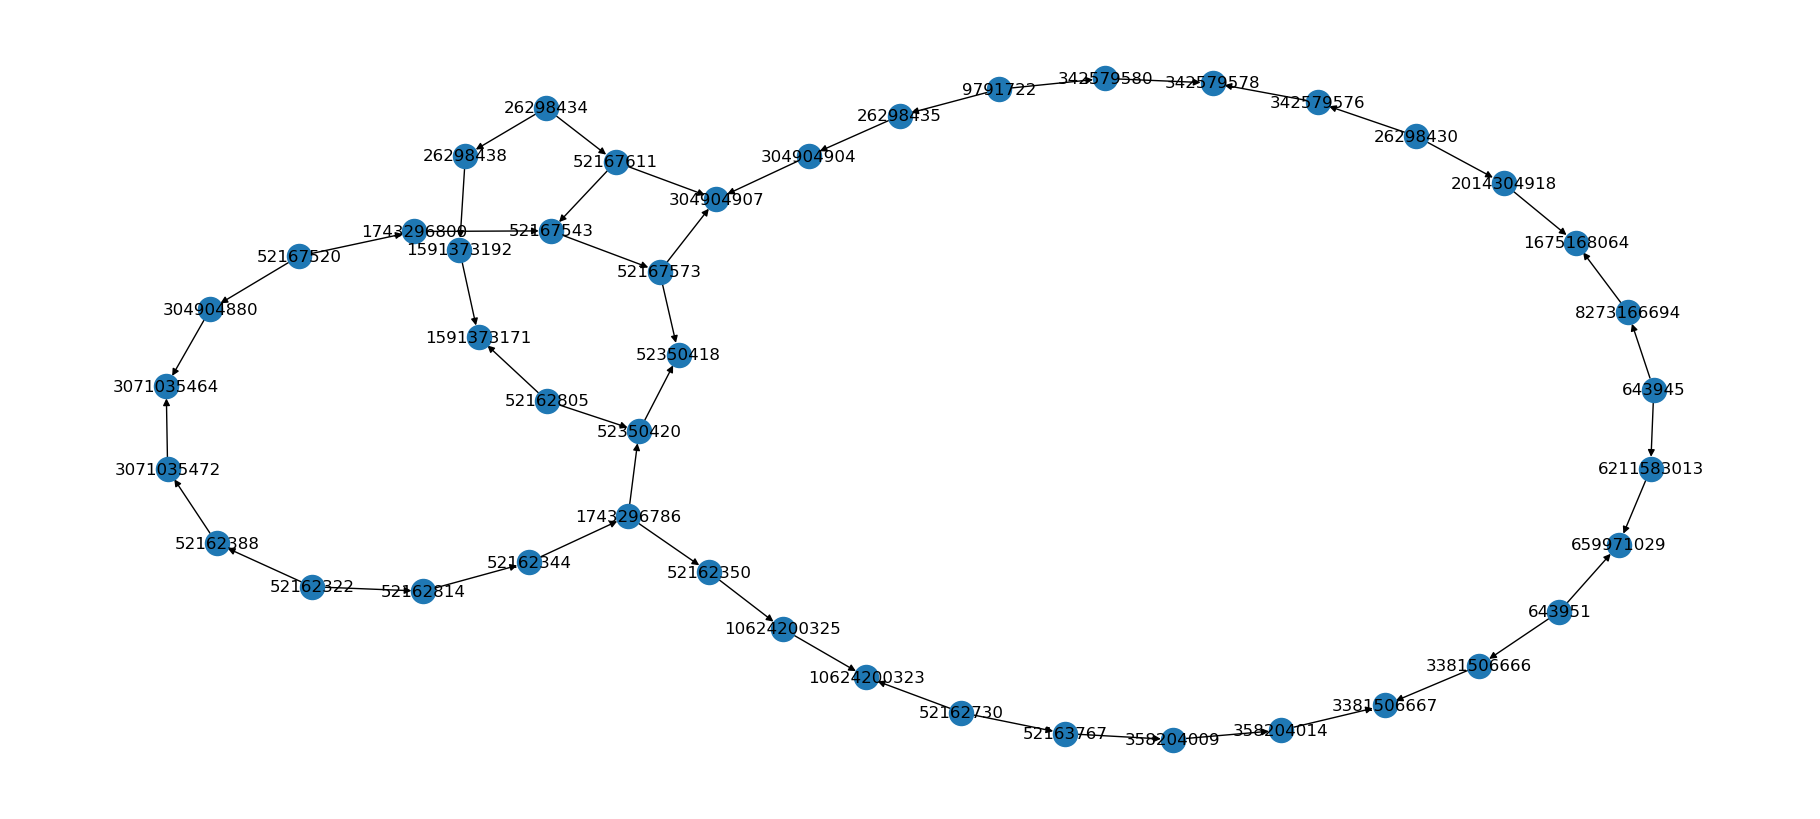

In [14]:
plt.figure(figsize=(18, 8))
nx.draw(kuratowski_subgraphs, pos=nx.kamada_kawai_layout(kuratowski_subgraphs), arrows=True, arrowstyle='-|>', with_labels=True)
plt.show()

<h2>Task B</h2>

In [15]:
# Some edges (roads in Soho) are missing a geometry, so we will create one
# assuming that the road is a direct line from start point to end point.
# First, we need to get the locations of the points
x_values = nx.get_node_attributes(G, 'x')
y_values = nx.get_node_attributes(G, 'y')

# We will work with the edges and add the missing geometries (lines denoting the roads between points)
graph_with_geometries = list(G.edges(data=True))

# Iterate through the edges and, where missing, add a geometry attribute with the line between start and end nodes
for e in graph_with_geometries:
    if not 'geometry' in e[2]:
        e[2]['geometry'] = LineString([
            Point(x_values[e[0]], y_values[e[0]]),
            Point(x_values[e[1]], y_values[e[1]])])

len(graph_with_geometries) # 365 Streets

365

In [16]:
# We will now drop the start and end nodes, as we will construct a new Spaghetti network based on the geometries of the roads
road_lines = [x[2] for x in graph_with_geometries]
# From this, we can construct a GeoDataFrame
roads_geodataframe = GeoDataFrame(pd.DataFrame(road_lines))
roads_geodataframe

osmid       highway lanes maxspeed              name  oneway   ref  \
0    229127796         trunk     3   30 mph       East Street    True   A61   
1     87797769    trunk_link     3   30 mph  Crown Point Road    True  A653   
2     27224242         trunk     2   30 mph       Duke Street    True   A61   
3    845622691         trunk     3   30 mph          Eastgate    True   A61   
4     27478791    trunk_link     1   20 mph               NaN    True   NaN   
..         ...           ...   ...      ...               ...     ...   ...   
360   53014870         trunk     2   30 mph     Regent Street    True   A61   
361   53014871  unclassified     1   20 mph      Byron Street    True   NaN   
362    6072859  unclassified   NaN      NaN      Byron Street    True   NaN   
363   53014870         trunk     2   30 mph     Regent Street    True   A61   
364  114459026  unclassified   NaN      NaN  Playhouse Square   False   NaN   

    reversed     length                                           geometry  \
0      False  32.104149  LINESTRING (-1.53392 53.79492, -1.53408 53.79519)   
1      False   7.979067    LINESTRING (-1.5327 53.79565, -1.5326 53.79569)   
2      False  70.399000  LINESTRING (-1.5327 53.79565, -1.53229 53.7954...   
3      False  15.623148  LINESTRING (-1.53604 53.79839, -1.53608 53.798...   
4      False  46.416758  LINESTRING (-1.53488 53.7965, -1.5348 53.79653...   
..       ...        ...                                                ...   
360    False  10.460708  LINESTRING (-1.53295 53.80241, -1.53298 53.80232)   
361    False  15.287264  LINESTRING (-1.53295 53.80241, -1.53297 53.802...   
362    False  50.042100  LINESTRING (-1.53298 53.80232, -1.53293 53.802...   
363    False  65.406525  LINESTRING (-1.53298 53.80232, -1.533 53.80224...   
364     True  43.195787  LINESTRING (-1.53394 53.79879, -1.53387 53.798...   

       junction width access bridge tunnel  
0           NaN   NaN    NaN    NaN    NaN  
1           NaN   NaN    NaN    NaN    NaN  
2           NaN   NaN    NaN    NaN    NaN  
3    roundabout   NaN    NaN    NaN    NaN  
4           NaN   NaN    NaN    NaN    NaN  
..          ...   ...    ...    ...    ...  
360         NaN   NaN    NaN    NaN    NaN  
361         NaN   NaN    NaN    NaN    NaN  
362         NaN   NaN    NaN    NaN    NaN  
363         NaN   NaN    NaN    NaN    NaN  
364         NaN   NaN    NaN    NaN    NaN  

[365 rows x 15 columns]

In [17]:
# From the GeoDataFrame, we can construct a network in Spaghetti from which to do point analysis
leeds_points_graph = spaghetti.Network(in_data=roads_geodataframe)

<Axes: >

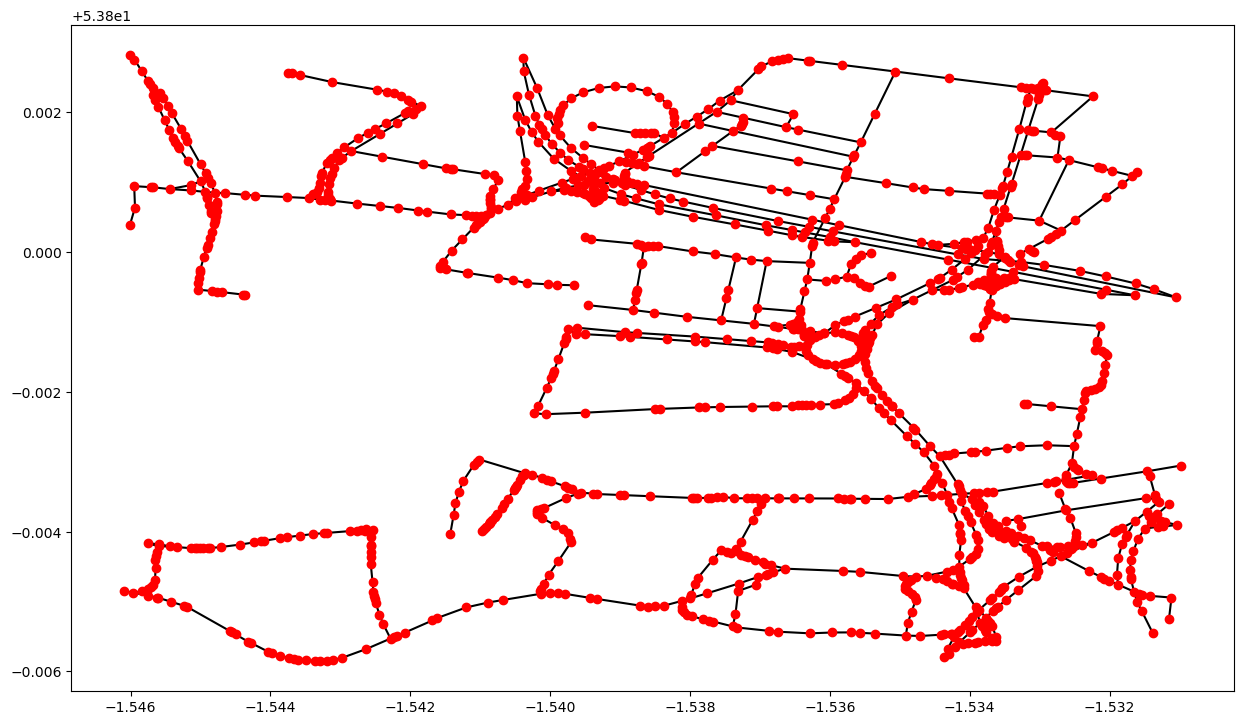

In [18]:
# Check what this new network looks like by getting DataFrames for the edges and plotting them
nodes_df, edges_df = spaghetti.element_as_gdf(
    leeds_points_graph, vertices=True, arcs=True)

base_network = edges_df.plot(color="k", zorder=0, figsize=(15, 15))
nodes_df.plot(ax=base_network, color="r", zorder=2)

In [19]:
# We will now snap the Leeds located accidents we extracted earlier, i.e. position them at the closest point on the closest road
leeds_points_graph.snapobservations(leeds_accidents, 'accidents')

# We can see the difference between the original crime coordinates and their position when snapped to the road network
print("observation 1\ntrue coords:\t%s\nsnapped coords:\t%s" % (
    leeds_points_graph.pointpatterns["accidents"].points[0]["coordinates"],
    leeds_points_graph.pointpatterns["accidents"].snapped_coordinates[0]
))

/opt/anaconda3/envs/nda/lib/python3.13/site-packages/spaghetti/network.py:3412: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  pts = [cg.shapes.Point((p.x, p.y)) for p in pts_objs]
/opt/anaconda3/envs/nda/lib/python3.13/site-packages/spaghetti/util.py:572: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  return cg.Chain([cg.Point(_vcoords[v]) for v in _vs] if _vcoords else _vs)
/opt/anaconda3/envs/nda/lib/python3.13/site-packages/libpysal/cg/shapes.py:1025: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  self._bounding_box = Rectangle(


observation 1
true coords:	(-1.724034571018721, 53.87705573246819)
snapped coords:	(-1.5460047, 53.8028155)


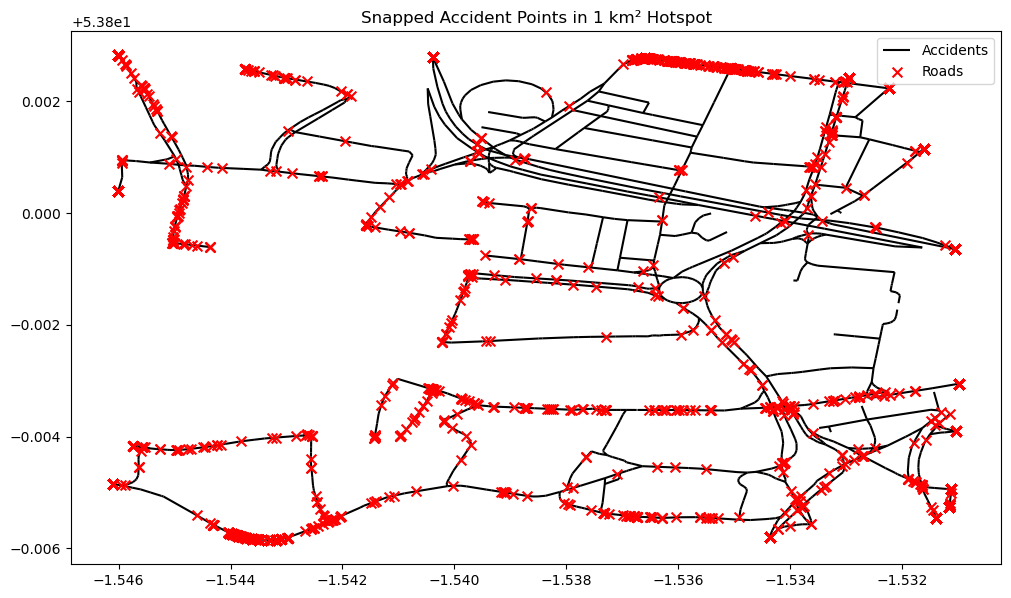

In [20]:
# Show the network
base_network = edges_df.plot(color="k", zorder=0, figsize =(12, 12))
# Get a GeoDataFrame of the snapped crime locations to plot on the network image
snapped_crimes=spaghetti.element_as_gdf(
    leeds_points_graph, pp_name='accidents', snapped=True)

# Plot these on the road network
snapped_crimes.plot(
    color="r", marker="x",
    markersize=50, zorder=1, ax=base_network)

plt.legend(["Accidents", "Roads"])
plt.title("Snapped Accident Points in 1 km² Hotspot")
plt.show()

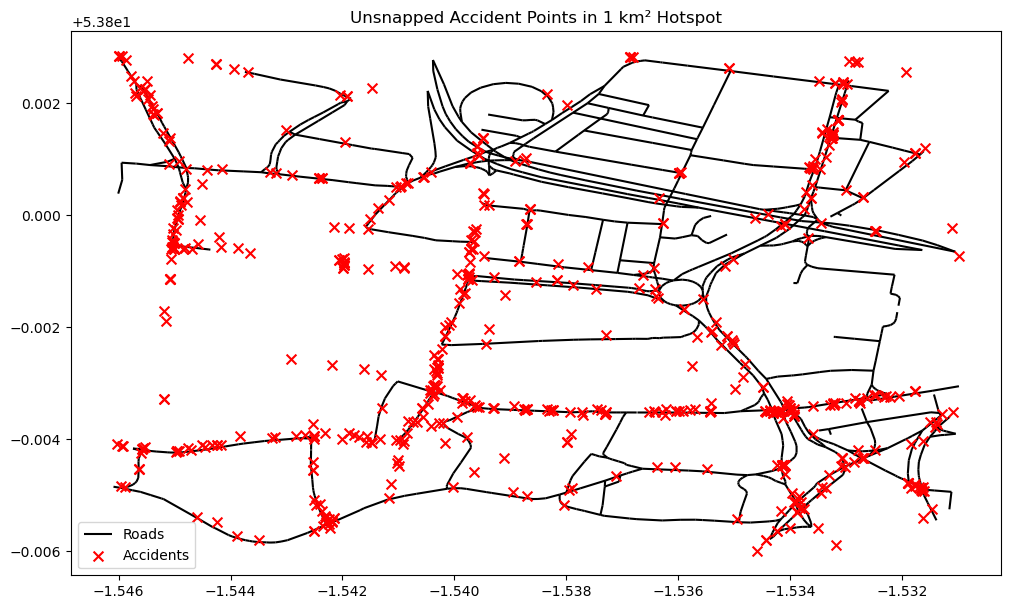

In [21]:
# Show the network
base_network = edges_df.plot(color="k", zorder=0, figsize =(12, 12))

snapped_crimes = spaghetti.element_as_gdf(
    leeds_points_graph, pp_name='accidents', snapped=False)

square_gdf = gpd.GeoSeries([bestSquare], crs="EPSG:27700").to_crs("EPSG:4326")
square_polygon = square_gdf.union_all()

snapped_crimes = snapped_crimes[snapped_crimes.geometry.within(square_polygon)]

snapped_crimes.plot(
    color="r", marker="x",
    markersize=50, zorder=1, ax=base_network)

plt.legend(["Roads", "Accidents"])
plt.title("Unsnapped Accident Points in 1 km² Hotspot")
plt.show()


In [22]:
kres = leeds_points_graph.GlobalAutoK(leeds_points_graph.pointpatterns["accidents"], nsteps=10, permutations=1)

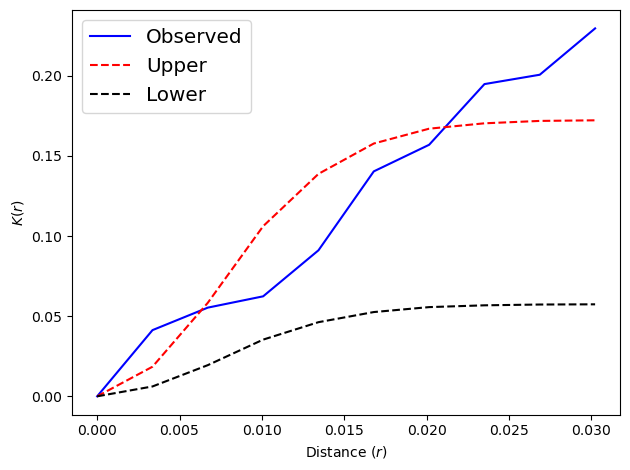

In [23]:
fig, ax = plt.subplots()

ax.plot(kres.xaxis, kres.observed, "b-", label="Observed")
ax.plot(kres.xaxis, kres.upperenvelope, "r--", label="Upper")
ax.plot(kres.xaxis, kres.lowerenvelope, "k--", label="Lower")

ax.legend(loc="best", fontsize="x-large")
ax.set_xlabel("Distance $(r)$")
ax.set_ylabel("$K(r)$")

fig.tight_layout()

In [24]:
# Get snapped point pattern
pointpat = leeds_points_graph.pointpatterns['accidents']
# Get count of points per network edge: a dictionary from each edge to the crime count on that edge
counts = leeds_points_graph.count_per_link(pointpat.obs_to_arc, graph=False)
# Get the weights matrix for edges in the graph (just the adjacency matrix with 1 where edges connect at a node, 0 otherwise)
weights = leeds_points_graph.w_network
# Get the edges included in the weights matrix: an enumerator for a list of edges
edges = weights.neighbors.keys()
# Construct an array of the counts values per edge in the same order as
# the weights matrix, with 0.0 where no counts recorded
values = [counts[edge] if edge in counts.keys () else 0. \
    for index, edge in enumerate(edges)]

moran = esda.moran.Moran(values, weights)

print(f"Moran's I: {moran.I}")
print(f"P-value: {moran.p_sim}")

Moran's I: 0.0037896405881177927
P-value: 0.09


In [25]:
rows = []
for i in snapped_crimes.iterrows():
    # build each row as a dictionary
    row_dict = {}
    rows.append(row_dict)
print(row_dict)

{}


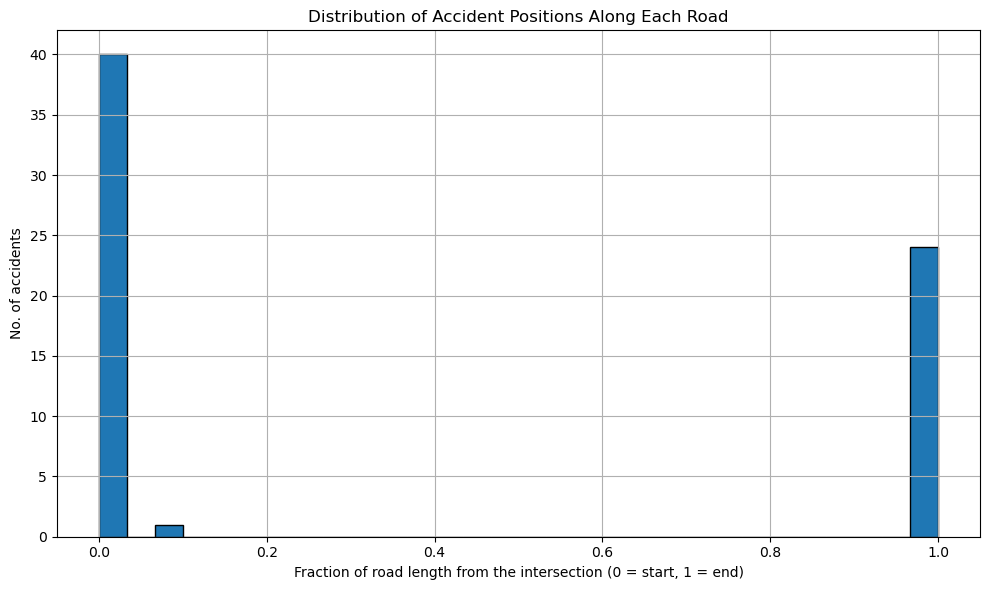

In [26]:
import geopandas as gpd
import matplotlib.pyplot as plt

edges_gdf = spaghetti.element_as_gdf(leeds_points_graph, arcs=True)

# List to store fraction along road
fractions = []

for _, j in snapped_crimes.iterrows():
    accidentPoint = j.geometry
    id = j.id
    try:
        roadGeometry = edges_gdf.loc[id].geometry
    except KeyError:
        # In case the arc ID doesn't exist in edges_gdf
        fractions.append(None)
        continue
    distanceAlongRoad = roadGeometry.project(accidentPoint)
    if roadGeometry.length > 0:
        frac = distanceAlongRoad / roadGeometry.length
    else:
        None
    fractions.append(frac)

# Store in dataframe
snapped_crimes["distance_fraction"] = fractions


# Plot histogram of where accidents fall along segments
plt.figure(figsize=(10, 6))
plt.hist(
    snapped_crimes["distance_fraction"].dropna(), 
    bins=30, 
    edgecolor='black'
)
plt.xlabel("Fraction of road length from the intersection (0 = start, 1 = end)")
plt.ylabel("No. of accidents")
plt.title("Distribution of Accident Positions Along Each Road")
plt.grid(True)
plt.tight_layout()
plt.show()


<h2>Task C</h2>

In [27]:
PLACE_OF_INTEREST = "Leeds, United Kingdom"
leeds_graph_full = ox.graph_from_place(PLACE_OF_INTEREST)

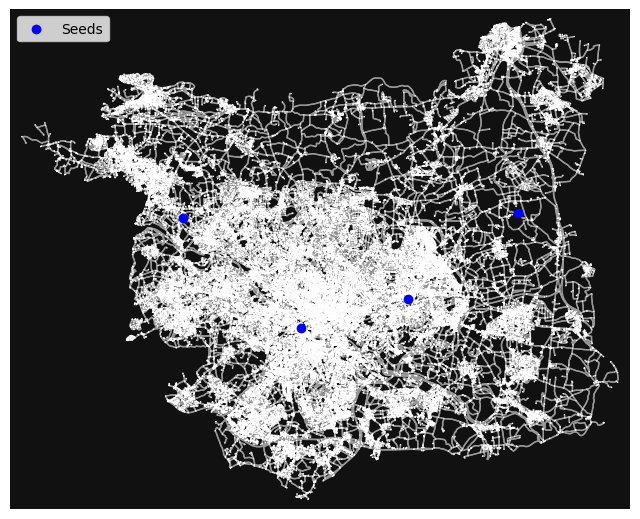

In [28]:
NUMBER_OF_SEEDS = 4
nodes = list(leeds_graph_full.nodes)

seedCoordinates = []
for i in nodes:
    x = leeds_graph_full.nodes[i]['x']
    y = leeds_graph_full.nodes[i]['y']
    seedCoordinates.append((x,y))
CoordinatesArray = np.array(seedCoordinates)

kmeans = KMeans(n_clusters = NUMBER_OF_SEEDS, random_state = 42)
kmeans.fit(CoordinatesArray)
centroids = kmeans.cluster_centers_

seeds = ox.nearest_nodes(leeds_graph_full, X = centroids[:, 0], Y = centroids[:, 1])


fig, ax = ox.plot_graph(leeds_graph_full, show = False, node_size = 1)
ax.scatter(centroids[:, 0], centroids[:, 1], c = 'blue', label = 'Seeds')
ax.legend()
plt.show()


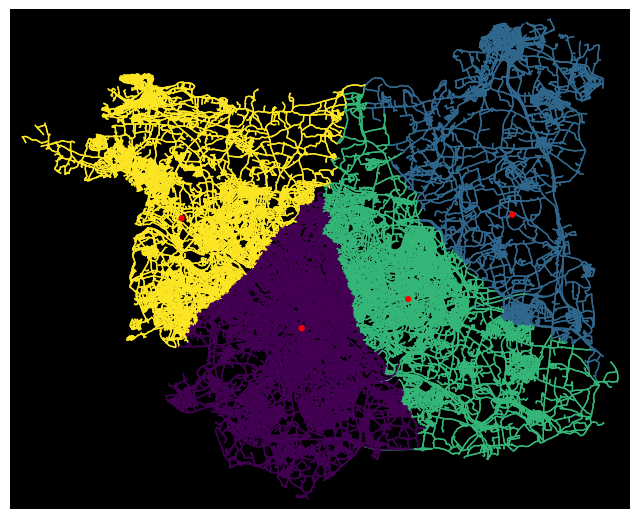

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [29]:
distances = {seed: nx.single_source_dijkstra_path_length(
    leeds_graph_full, seed, weight='length') for seed in seeds}

black_color = 'k'
seeds = list(seeds)


def nearest_from_list(node_distances):
    return sorted(node_distances, key=lambda node_length: node_length[1])[0] \
        if len(node_distances) > 0 else None

def nearest_seed(node):
    seed_distances = [(seed, distances[seed][node]) \
        for seed in seeds if node in distances[seed]]
    return nearest_from_list(seed_distances)

def nearest_for_edge(edge):
    nearest_to_ends_all = [nearest_seed(edge[0]), nearest_seed(edge[1])]
    nearest_to_ends = [distance for distance in nearest_to_ends_all if distance]
    return nearest_from_list(nearest_to_ends)

colours = ox.plot.get_colors(NUMBER_OF_SEEDS)

def colour_for_seed_distance(seed):
    return colours[seeds.index(seed[0])]


edge_nearest_seeds = [nearest_for_edge(edge) for edge in leeds_graph_full.edges]
# Note that edges not connected to a seed shown in black, so invisible on black background
edge_colours = [colour_for_seed_distance(seed) if seed else black_color for seed in edge_nearest_seeds]
# For the road network nodes, we want the seeds to be coloured red and the non-seed nodes to be coloured white.
node_colours = ['r' if node in seeds else 'none' for node in nodes]

ox.plot.plot_graph(leeds_graph_full, edge_color = edge_colours, node_color = node_colours, bgcolor = 'k', node_size=20, save = True, filepath = 'nvd.png')

In [30]:
seeds = ox.nearest_nodes(leeds_graph_full, X=centroids[:, 0], Y=centroids[:, 1])
seeds = list(seeds) 
node_region_map = {}  # node_id → region_index

for node in leeds_graph_full.nodes:
    min_seed = nearest_seed(node)
    if min_seed is not None:
        region_index = seeds.index(min_seed[0])
        node_region_map[node] = region_index
    else:
        continue
    
for node, region in node_region_map.items():
    leeds_graph_full.nodes[node]['region'] = region
    
NUMBER_OF_SEEDS = len(seeds)
seed_graphs = []

for region_id in range(NUMBER_OF_SEEDS):
    region_nodes = []
    for n, data in leeds_graph_full.nodes(data=True):
        if data.get('region') == region_id:
            region_nodes.append(n)
    region_subgraph = leeds_graph_full.subgraph(region_nodes).copy()
    seed_graphs.append(region_subgraph)

print(f"Got {len(seed_graphs)} subgraph regions.")



Got 4 subgraph regions.


In [31]:
targetLength = 42000
tolerance = 500

def findPath(seed_graph):
    
    G = nx.Graph(seed_graph)
    
    cycles = nx.cycle_basis(G)
    validCycles = []

    for cycle in cycles:
        try:
            totalLength = 0
            edges = list(zip(cycle, cycle[1:] + [cycle[0]]))
            for x, y in edges:
                if G.has_edge(x, y):
                    edge_data = G.get_edge_data(x, y)
                    if isinstance(edge_data, dict) == True:
                        edge_length = edge_data.get('length', 0)
                    else:
                        edge_length = edge_data[0].get('length', 0)
                    totalLength += edge_length
                else:
                    totalLength = 0
                    break
        except Exception:
            continue

        if targetLength - tolerance <= totalLength <= targetLength + tolerance:
            validCycles.append((cycle, totalLength))
            break

    validCycles = sorted(validCycles, key=lambda x: x[1], reverse=True)
    return validCycles


In [32]:
cycleResults = []
for i, subgraph in enumerate(seed_graphs):
    cycles = findPath(subgraph)
    if cycles:
        print(f"Region {i} -  Found a cycle. Length of path ≈ {cycles[0][1]/1000:.2f} km")
    else:
        print(f"Region {i} -  No valid cycles found.")
    cycleResults.append(cycles)

Region 0 -  Found a cycle. Length of path ≈ 42.11 km
Region 1 -  No valid cycles found.
Region 2 -  Found a cycle. Length of path ≈ 42.07 km
Region 3 -  Found a cycle. Length of path ≈ 41.67 km


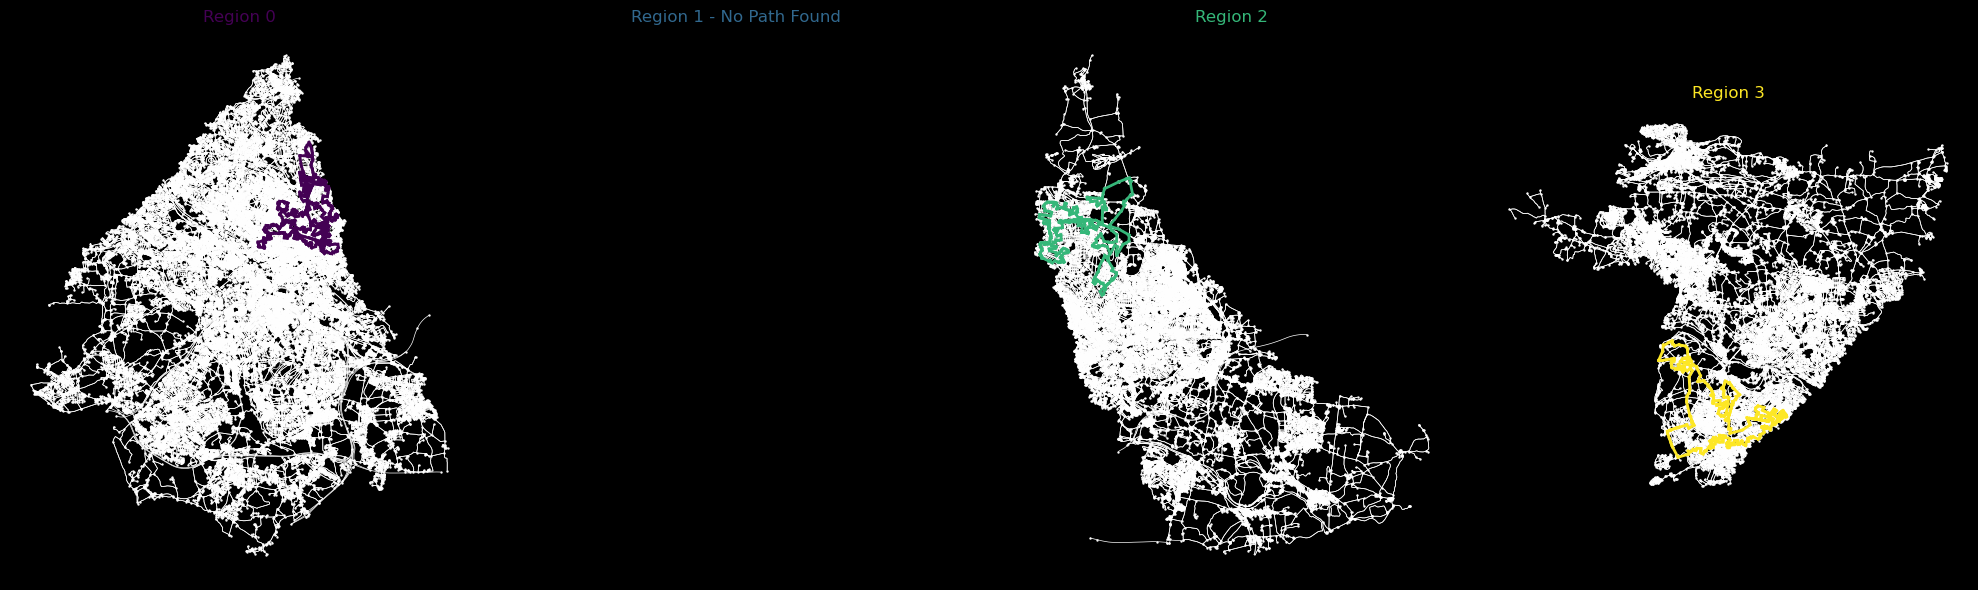

In [33]:
fig, axs = plt.subplots(1, 4, figsize = (20, 6), facecolor = 'black')

for i in range(len(seed_graphs)):
    subgraph = seed_graphs[i]
    cycleResult = cycleResults[i]
    ax = axs[i]

    if not cycleResult:
        ax.set_title(f"Region {i} - No Path Found", color=colours[i])
        ax.set_facecolor('black')
        ax.axis('off')
        continue

    loop_nodes = cycleResult[0][0]
    edges = list(zip(loop_nodes, loop_nodes[1:] + [loop_nodes[0]]))

    # Plot base subgraph
    edge_gdf = ox.graph_to_gdfs(subgraph, nodes=False)
    node_gdf = ox.graph_to_gdfs(subgraph, edges=False)

    edge_gdf.plot(ax=ax, linewidth=0.5, color='white')
    node_gdf.plot(ax=ax, markersize=0.5, color='white')

    for u, v in edges:
        edge_data = subgraph[u].get(v) or subgraph[v].get(u)

        x = [subgraph.nodes[u]["x"], subgraph.nodes[v]["x"]]
        y = [subgraph.nodes[u]["y"], subgraph.nodes[v]["y"]]

        ax.plot(x, y, color=colours[i], linewidth=2)

    ax.set_title(f"Region {i}", color=colours[i])
    ax.set_facecolor('black')
    ax.axis('off')

plt.tight_layout()
plt.show()


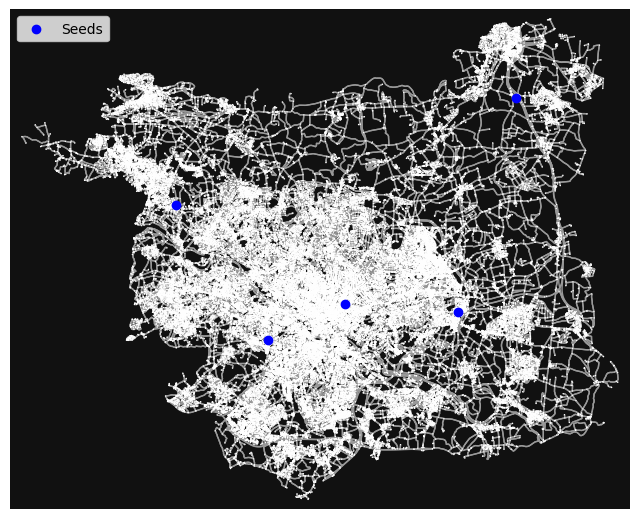

In [34]:
NUMBER_OF_SEEDS = 5
nodes = list(leeds_graph_full.nodes)

seedCoordinates = []
for i in nodes:
    x = leeds_graph_full.nodes[i]['x']
    y = leeds_graph_full.nodes[i]['y']
    seedCoordinates.append((x,y))
CoordinatesArray = np.array(seedCoordinates)

kmeans = KMeans(n_clusters = NUMBER_OF_SEEDS, random_state = 42)
kmeans.fit(CoordinatesArray)
centroids = kmeans.cluster_centers_

seeds = ox.nearest_nodes(leeds_graph_full, X = centroids[:, 0], Y = centroids[:, 1])


fig, ax = ox.plot_graph(leeds_graph_full, show = False, node_size = 1)
ax.scatter(centroids[:, 0], centroids[:, 1], c = 'blue', label = 'Seeds')
ax.legend()
plt.show()


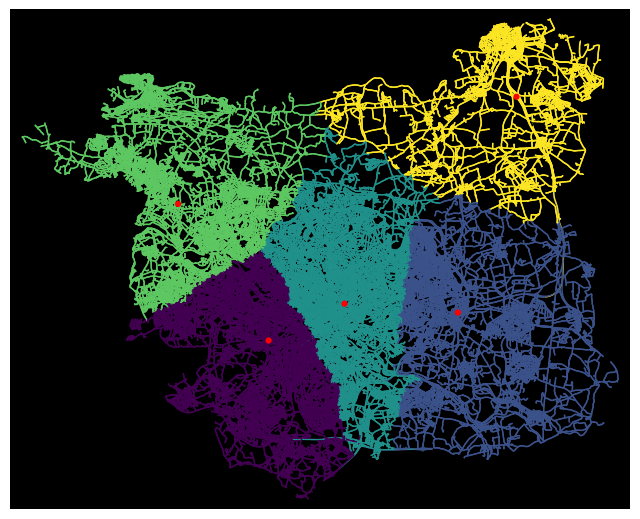

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [35]:
distances = {seed: nx.single_source_dijkstra_path_length(
    leeds_graph_full, seed, weight='length') for seed in seeds}

seeds = list(seeds)

colours = ox.plot.get_colors(NUMBER_OF_SEEDS)

edge_nearest_seeds = [nearest_for_edge(edge) for edge in leeds_graph_full.edges]
# Note that edges not connected to a seed shown in black, so invisible on black background
edge_colours = [colour_for_seed_distance(seed) if seed else black_color for seed in edge_nearest_seeds]
# For the road network nodes, we want the seeds to be coloured red and the non-seed nodes to be coloured white.
node_colours = ['r' if node in seeds else 'none' for node in nodes]

ox.plot.plot_graph(leeds_graph_full, edge_color = edge_colours, node_color = node_colours, bgcolor = 'k', node_size=20, save = True, filepath = 'nvd.png')

In [36]:
seeds = ox.nearest_nodes(leeds_graph_full, X=centroids[:, 0], Y=centroids[:, 1])
seeds = list(seeds) 
node_region_map = {}  # node_id → region_index

for node in leeds_graph_full.nodes:
    min_seed = nearest_seed(node)
    if min_seed is not None:
        region_index = seeds.index(min_seed[0])
        node_region_map[node] = region_index
    else:
        continue
    
for node, region in node_region_map.items():
    leeds_graph_full.nodes[node]['region'] = region
    
NUMBER_OF_SEEDS = len(seeds)
seed_graphs = []

for region_id in range(NUMBER_OF_SEEDS):
    region_nodes = []
    for n, data in leeds_graph_full.nodes(data=True):
        if data.get('region') == region_id:
            region_nodes.append(n)
    region_subgraph = leeds_graph_full.subgraph(region_nodes).copy()
    seed_graphs.append(region_subgraph)

print(f"Got {len(seed_graphs)} subgraph regions.")



Got 5 subgraph regions.


In [37]:
cycleResults = []
for i, subgraph in enumerate(seed_graphs):
    cycles = findPath(subgraph)
    if cycles:
        print(f"Region {i} -  Found a cycle. Length of path ≈ {cycles[0][1]/1000:.2f} km")
    else:
        print(f"Region {i} -  No valid cycles found.")
    cycleResults.append(cycles)

Region 0 -  Found a cycle. Length of path ≈ 41.52 km
Region 1 -  Found a cycle. Length of path ≈ 41.59 km
Region 2 -  Found a cycle. Length of path ≈ 41.78 km
Region 3 -  Found a cycle. Length of path ≈ 41.95 km
Region 4 -  Found a cycle. Length of path ≈ 42.49 km


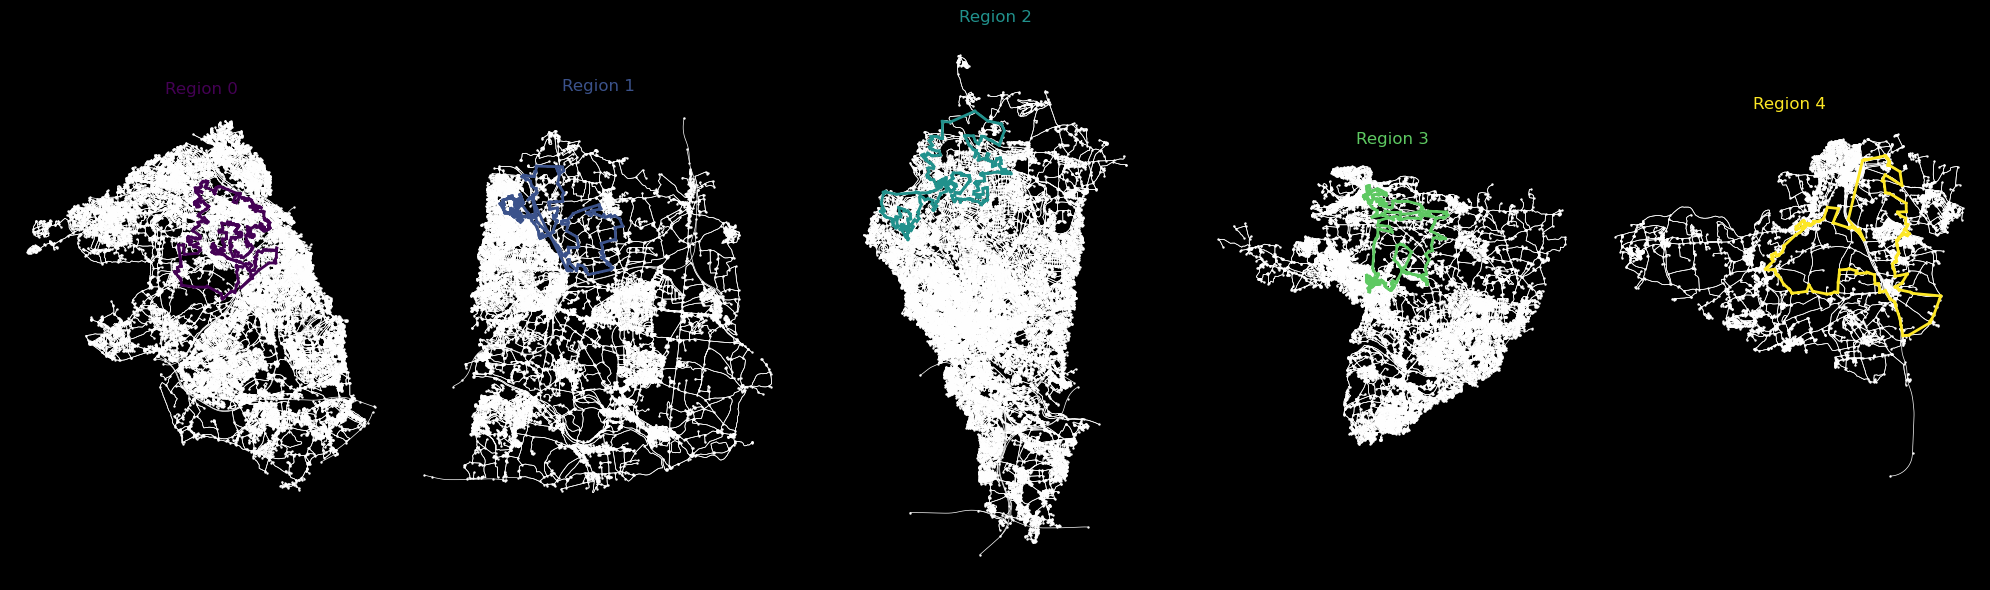

In [38]:
fig, axs = plt.subplots(1, 5, figsize = (20, 6), facecolor = 'black')

for i in range(len(seed_graphs)):
    subgraph = seed_graphs[i]
    cycleResult = cycleResults[i]
    ax = axs[i]

    if not cycleResult:
        ax.set_title(f"Region {i} - No Path Found", color=colours[i])
        ax.set_facecolor('black')
        ax.axis('off')
        continue

    loop_nodes = cycleResult[0][0]
    edges = list(zip(loop_nodes, loop_nodes[1:] + [loop_nodes[0]]))

    # Plot base subgraph
    edge_gdf = ox.graph_to_gdfs(subgraph, nodes=False)
    node_gdf = ox.graph_to_gdfs(subgraph, edges=False)

    edge_gdf.plot(ax=ax, linewidth=0.5, color='white')
    node_gdf.plot(ax=ax, markersize=0.5, color='white')

    for u, v in edges:
        edge_data = subgraph[u].get(v) or subgraph[v].get(u)

        x = [subgraph.nodes[u]["x"], subgraph.nodes[v]["x"]]
        y = [subgraph.nodes[u]["y"], subgraph.nodes[v]["y"]]

        ax.plot(x, y, color=colours[i], linewidth=2)

    ax.set_title(f"Region {i}", color=colours[i])
    ax.set_facecolor('black')
    ax.axis('off')

plt.tight_layout()
plt.show()


<h2>Task D</h2>

In [39]:
# Create a new provenance document
d1 = ProvDocument()

# Declaring namespaces for various prefixes used in the example
d1.add_namespace('now', 'http://www.provbook.org/nownews/')
d1.add_namespace('nowpeople', 'http://www.provbook.org/nownews/people/')

# Entity: 
route = d1.entity('now:Route')
runnerData = d1.entity('now:RunnerData')
time = d1.entity('now:Time')
water = d1.entity('now:Water')
firstAidKit = d1.entity('now:firstAidKit')
medal = d1.entity('now:Medal')

# Agent:
runner = d1.agent('nowpeople:Runner')
mayor = d1.agent('nowpeople:Mayor')
timekeeper = d1.agent('nowpeople:Timekeeper')
volunteer = d1.agent('nowpeople:Volunteer')
medicalStaff = d1.agent('nowpeople:medicalStaff')
police = d1.agent('nowpeople:Police')
coach = d1.agent('nowpeople:Coach')

# Activity:
planMarathon = d1.activity('now:planMarathon')
planSafety = d1.activity('now:planSafety')
trainForMarathon = d1.activity('now:trainForMarathon')
registerParticpants = d1.activity('now:registerParticpants')
runMarathon = d1.activity('now:runMarathon')
trackTime = d1.activity('now:trackTime')
giveWater = d1.activity('now:giveWater')
awardMedals = d1.activity('now:awardMedals')

# Link agents to activities
d1.wasAssociatedWith(planMarathon, mayor)
d1.wasAssociatedWith(planSafety, medicalStaff)
d1.wasAssociatedWith(planSafety, police)
d1.wasAssociatedWith(trainForMarathon, coach)
d1.wasAssociatedWith(trainForMarathon, runner)
d1.wasAssociatedWith(registerParticpants, volunteer)
d1.wasAssociatedWith(runMarathon, runner)
d1.wasAssociatedWith(trackTime, timekeeper)
d1.wasAssociatedWith(giveWater, volunteer)
d1.wasAssociatedWith(awardMedals, mayor)

# Link usage of entities
d1.used(planMarathon, route)
d1.used(planSafety, firstAidKit)
d1.used(planSafety, water)
d1.used(trainForMarathon, runnerData)
d1.used(registerParticpants, runnerData)
d1.used(runMarathon, runnerData)
d1.used(runMarathon, route)
d1.used(trackTime, time)
d1.used(giveWater, water)
d1.used(awardMedals, time)
d1.used(awardMedals, medal)

d1.wasGeneratedBy(time, trackTime)
d1.wasGeneratedBy(medal, awardMedals)
d1.wasGeneratedBy(runner, trainForMarathon)   
d1.wasGeneratedBy(firstAidKit, planSafety)      
d1.wasGeneratedBy(route, planMarathon)  
        
d1.wasDerivedFrom(medal, time)
d1.wasDerivedFrom(runnerData, runner)     
d1.wasDerivedFrom(medal, runner)     


<ProvDerivation: (now:Medal, nowpeople:Runner)>

In [40]:
# visualize the graph
from prov.dot import prov_to_dot
dot = prov_to_dot(d1)
dot.write_png('article-prov.png')

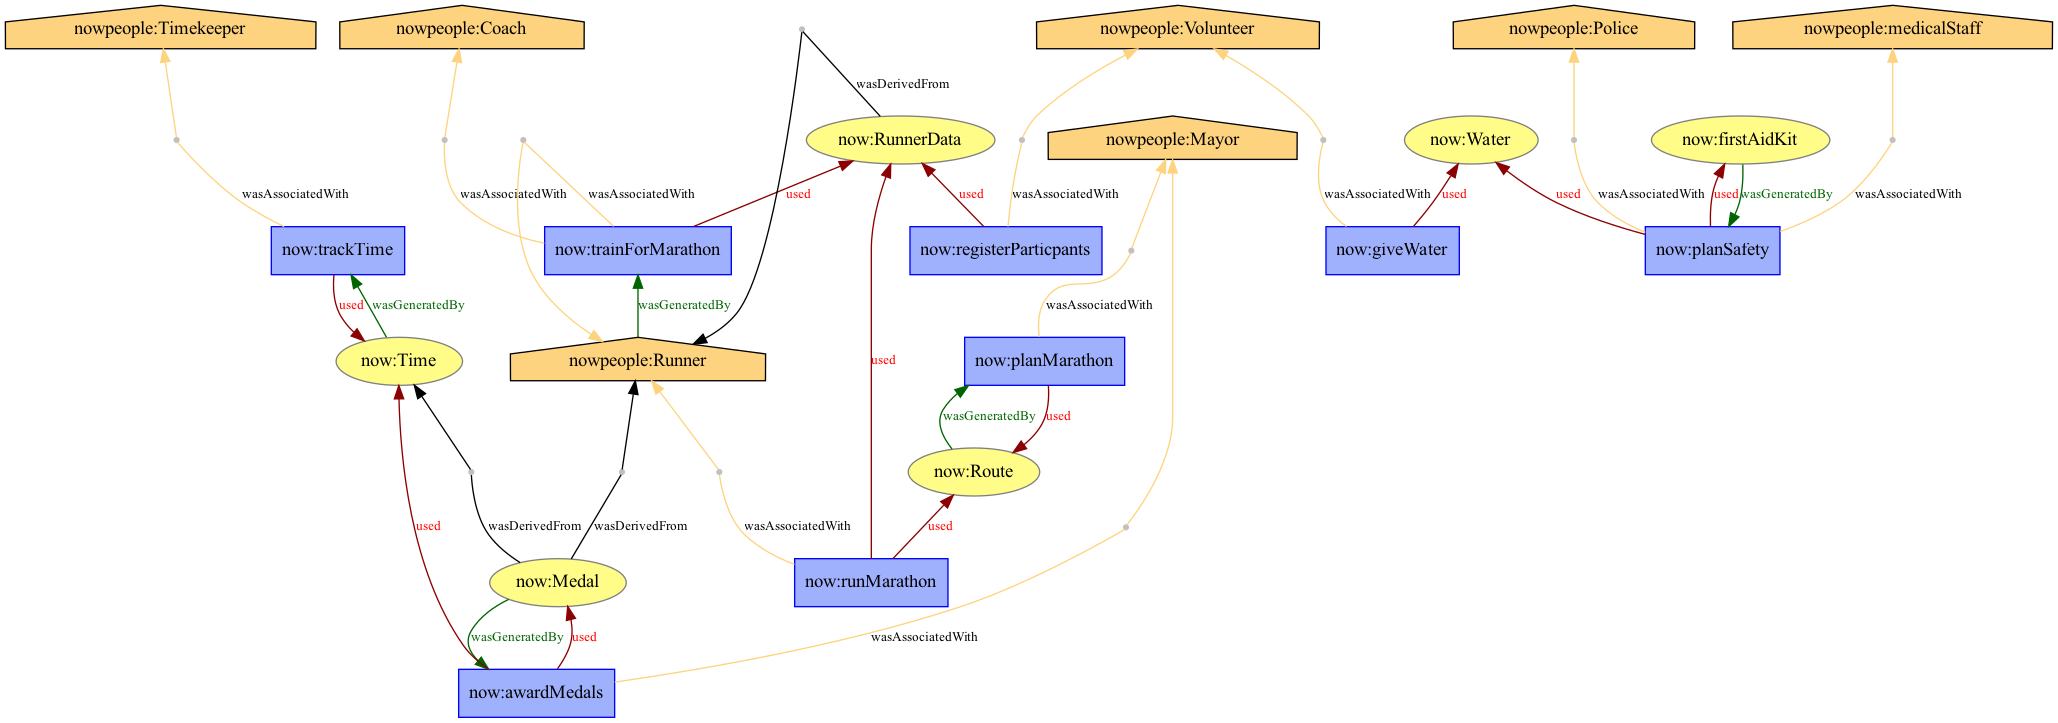

In [41]:
from IPython.display import Image
Image('article-prov.png')

In [42]:
from prov.graph import prov_to_graph

# Convert ProvDocument to MultiDiGraph
g = prov_to_graph(d1)

In [43]:
# Output graph data
print("Number of nodes:", g.number_of_nodes())
print("Number of edges:", g.number_of_edges())

Number of nodes: 21
Number of edges: 29


In [44]:
pagerank = nx.pagerank(g)
pagerank

{<ProvEntity: now:Route>: 0.04887998632400416,
 <ProvEntity: now:RunnerData>: 0.06540999373599304,
 <ProvEntity: now:Time>: 0.06339736041585868,
 <ProvEntity: now:Water>: 0.0348118262883045,
 <ProvEntity: now:firstAidKit>: 0.027044542193877294,
 <ProvEntity: now:Medal>: 0.025501297964469226,
 <ProvAgent: nowpeople:Runner>: 0.12046550011032324,
 <ProvAgent: nowpeople:Mayor>: 0.050927205096278814,
 <ProvAgent: nowpeople:Timekeeper>: 0.048946544078739766,
 <ProvAgent: nowpeople:Volunteer>: 0.033810457984764175,
 <ProvAgent: nowpeople:medicalStaff>: 0.027044542193877294,
 <ProvAgent: nowpeople:Police>: 0.027044542193877294,
 <ProvAgent: nowpeople:Coach>: 0.052464520245281025,
 <ProvActivity: now:planMarathon>: 0.05982470793708477,
 <ProvActivity: now:planSafety>: 0.04126389561552308,
 <ProvActivity: now:trainForMarathon>: 0.12066916468208222,
 <ProvActivity: now:registerParticpants>: 0.018275889795909765,
 <ProvActivity: now:runMarathon>: 0.018275889795909765,
 <ProvActivity: now:trackTime

In [45]:
def plot_pagerank(graph, pagerank):
    fig, ax = plt.subplots(1, 1, figsize=(8, 7))

    labels = dict(zip(set(graph.nodes()), range(len(set(graph.nodes())))))
    node_color = list(pagerank.values())
    nx.draw(graph, with_labels=True, alpha=0.8, arrows=False, node_size=300, node_color=node_color, cmap=plt.cm.viridis, labels=labels)

    # adding color bar for pagerank importances
    sm = plt.cm.ScalarMappable(cmap=plt.get_cmap('viridis'), norm=colors.Normalize(vmin=min(node_color), vmax=max(node_color)))
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="2%", pad=0.05)
    plt.colorbar(sm, cax=cax)

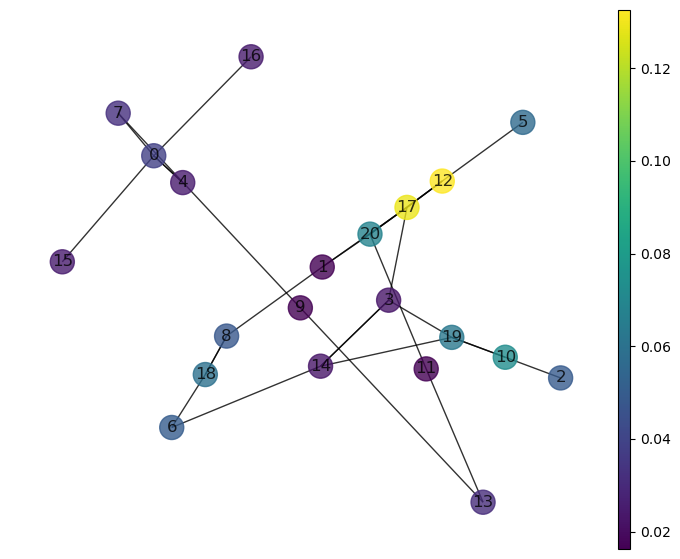

In [46]:
pagerank = nx.pagerank(g, alpha=0.9)
plot_pagerank(g, pagerank)

Text(0, 0.5, 'PageRank value')

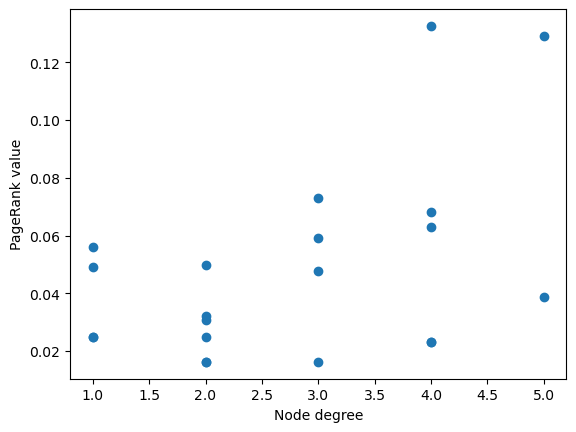

In [47]:
pagerank_sorted_desc = dict(sorted(pagerank.items(), key=lambda item: item[1], reverse=True))
node_degree = {k: v for k, v in g.degree(pagerank_sorted_desc.keys())}

x = node_degree.values()
y = pagerank_sorted_desc.values()

fig, ax = plt.subplots()
ax.scatter(x, y)
ax.set_xlabel('Node degree')
ax.set_ylabel('PageRank value')